Partnered with Wayne Lu to complete this assignment 

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
print("gradient", grad)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

gradient [[ -2.91903084e+00  -8.93685510e-01  -2.80674641e-01 ...,   4.62727074e-01
   -2.82217860e+00  -2.59604602e+00]
 [ -3.42628422e+00  -5.23430670e-01  -3.35737148e-03 ...,  -1.97728154e-01
   -3.49028565e+00  -3.26540848e+00]
 [ -5.29587389e+00  -5.72646300e-01   6.57421646e-01 ...,  -5.39166999e-01
   -4.76687559e+00  -4.24353697e+00]
 ..., 
 [  2.19355478e-01   5.17205356e-01  -1.51465948e+00 ...,  -1.59838207e+00
    1.68683975e+00   5.69552580e-02]
 [ -5.09901007e-01  -3.59839322e-01  -1.42126212e+00 ...,  -4.21175046e-01
   -2.90135282e-02  -2.89636778e-01]
 [ -1.44492038e-02   8.48728428e-03   1.18943814e-02 ...,  -7.39750886e-03
   -4.19877548e-03   2.38350781e-02]]
loss: 2.356788
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


We expect our loss to be close to -log(0.1), because: 

In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
print("numeric gradient checking as a debugging tool")
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
print("gradient check with regularization")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numeric gradient checking as a debugging tool
numerical: -3.069892 analytic: -3.069892, relative error: 2.174700e-08
numerical: -3.290849 analytic: -3.290849, relative error: 6.635600e-09
numerical: 2.113657 analytic: 2.113657, relative error: 1.815333e-08
numerical: 1.849958 analytic: 1.849958, relative error: 3.557982e-08
numerical: -0.551418 analytic: -0.551419, relative error: 1.103069e-08
numerical: 1.958243 analytic: 1.958243, relative error: 2.517374e-08
numerical: 0.309322 analytic: 0.309322, relative error: 9.301085e-08
numerical: 1.811798 analytic: 1.811798, relative error: 1.603747e-08
numerical: -0.141959 analytic: -0.141959, relative error: 2.634270e-07
numerical: -1.041993 analytic: -1.041993, relative error: 5.883239e-08
gradient check with regularization
numerical: -1.313621 analytic: -1.315104, relative error: 5.640751e-04
numerical: -0.521065 analytic: -0.520999, relative error: 6.263148e-05
numerical: -2.803637 analytic: -2.813875, relative error: 1.822433e-03
numeri

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster 

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)


naive loss: 2.356788e+00 computed in 0.092347s
vectorized loss: 2.356788e+00 computed in 0.005597s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

iters = 2000 #100  

for lr in learning_rates: 
    for reg  in regularization_strengths: 
        softmax= Softmax() #training softmax
        softmax.train(X_train, y_train, learning_rate= lr, reg= reg, num_iters= iters, verbose=  True)
        
        y_train_pred = softmax.predict(X_train)
        train_accuc = np.mean(y_train == y_train_pred) #training acc
        
        y_val_pred = softmax.predict (X_val)
        val_accuc = np.mean(y_val == y_val_pred) # validation acc 
        
        #storing #'s of training and validation accuc 
        results[lr, reg] = (train_accuc, val_accuc)
        
        #storing best valalidation acc (best_val). for best_svm
        if best_val < val_accuc: 
            best_val = val_accuc # making best_val  = val_acc 
            best_softmax = softmax
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# at 100 iters, best validation accuracy achieved during cross-validation: 0.320000
#2000= 36.8

iteration 0 / 2000: loss 776.243890
iteration 100 / 2000: loss 468.974008
iteration 200 / 2000: loss 284.149595
iteration 300 / 2000: loss 172.455230
iteration 400 / 2000: loss 105.302636
iteration 500 / 2000: loss 64.497882
iteration 600 / 2000: loss 39.881843
iteration 700 / 2000: loss 24.957357
iteration 800 / 2000: loss 15.890942
iteration 900 / 2000: loss 10.501771
iteration 1000 / 2000: loss 7.202154
iteration 1100 / 2000: loss 5.139235
iteration 1200 / 2000: loss 3.997192
iteration 1300 / 2000: loss 3.256118
iteration 1400 / 2000: loss 2.745630
iteration 1500 / 2000: loss 2.543378
iteration 1600 / 2000: loss 2.362923
iteration 1700 / 2000: loss 2.244911
iteration 1800 / 2000: loss 2.150693
iteration 1900 / 2000: loss 2.152294
iteration 0 / 2000: loss 1544.581163
iteration 100 / 2000: loss 566.432416
iteration 200 / 2000: loss 208.475175
iteration 300 / 2000: loss 77.755764
iteration 400 / 2000: loss 29.892712
iteration 500 / 2000: loss 12.302353
iteration 600 / 2000: loss 5.9247

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.364000


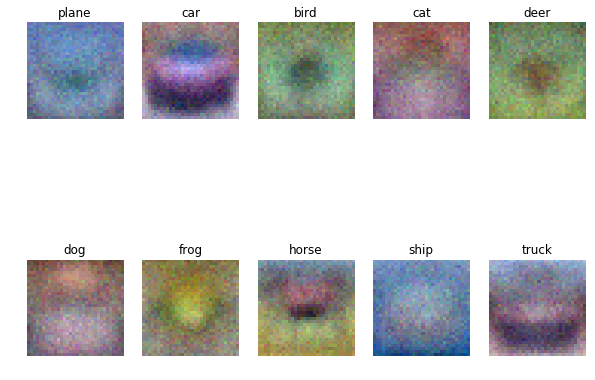

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])